In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook
import datetime as dt
from scipy.stats import norm
import requests
import json

In [2]:
def yahoo_opt_clean(x, type):
    x = pd.io.json.json_normalize(x['optionChain']['result'][0]['options'][0][type])
    x = x[['ask', 'bid', 'expiration', 'strike', 'inTheMoney']]
    if type == 'calls':
        x['type'] = 'C'
    elif type == 'puts':
        x['type'] = 'P'
    else:
        raise ValueError('Unknown option type')
    return x


def get_options():
    url = 'https://query2.finance.yahoo.com/v7/finance/options/SPY'
    content = requests.get(url).text
    content = json.loads(content)
    current_price = content['optionChain']['result'][0]['quote']['regularMarketPrice']
    current_date = content['optionChain']['result'][0]['quote']['regularMarketTime']
    dates = content['optionChain']['result'][0]['expirationDates']
    options = yahoo_opt_clean(content, 'calls')
    df = yahoo_opt_clean(content, 'puts')
    options = options.append(df, ignore_index=True)
    for i in range(1, len(dates)):
        content = requests.get(url + '?date=' + str(dates[i])).text
        content = json.loads(content)
        num_strikes = len(content['optionChain']['result'][0]['strikes'])
        if num_strikes > 1:
            df = yahoo_opt_clean(content, 'calls')
            options = options.append(df, ignore_index=True)
            df = yahoo_opt_clean(content, 'puts')
            options = options.append(df, ignore_index=True)
        else:
            break
    return options, current_price, current_date

options, current_price, date = get_options()

In [3]:
options.drop(options[options.inTheMoney == True].index, inplace=True)
options['price'] = (options['ask'] - options['bid'])/2 + options['bid']
options.drop(['ask', 'bid', 'inTheMoney'], axis=1, inplace=True)
options.reset_index(drop=True, inplace=True)
date = dt.datetime.fromtimestamp(int(date))
round_price = round(current_price/5)*5

In [4]:
df = options.copy(deep=True)
# Pivot
df = df.pivot(index='expiration', columns='strike', values='price')

# Drop low and high columns
df = df[[c for c in df.columns if c <= (round_price + 50)]]
df = df[[c for c in df.columns if c >= (round_price - 50)]]

# Drop columns which aren't divisible by 5
df = df[[c for c in df.columns if c % 5 == 0]]
# Drop rows with many nans
df.dropna(axis=0, thresh=df.shape[1]-3, inplace=True)
# Drop columns with any nans
df.dropna(axis=1, how='any', inplace=True)
# Convert the index to number of days from today
df.index = pd.to_datetime(df.index, unit='s')
df.index = (df.index - date).days
# Drop days farther than one year
df = df[df.index < 366]

In [5]:
df.head(20)

strike,220.0,225.0,230.0,235.0,240.0,245.0,250.0,255.0,260.0,265.0,270.0,275.0,280.0,285.0,290.0,295.0,300.0,310.0
expiration,,,,,,,,,,,,,,,,,,
9,0.065,0.085,0.105,0.135,0.170,0.220,0.310,0.460,0.745,1.320,2.430,1.245,0.220,0.035,0.015,0.005,0.010,0.005
16,0.160,0.195,0.240,0.330,0.375,0.485,0.650,0.905,1.320,1.995,3.175,1.960,0.565,0.135,0.045,0.020,0.010,0.005
36,0.420,0.490,0.610,0.745,0.920,1.165,1.490,1.940,2.570,3.500,4.915,3.045,1.315,0.490,0.175,0.070,0.040,0.020
58,0.750,0.880,1.060,1.270,1.545,1.880,2.320,2.880,3.625,4.650,6.105,4.335,2.255,1.045,0.445,0.190,0.105,0.030
86,1.150,1.360,1.610,1.910,2.275,2.725,3.285,3.985,4.870,6.015,7.500,6.080,3.640,1.975,1.000,0.505,0.265,0.100
114,1.600,1.880,2.210,2.595,3.065,3.615,4.280,5.095,6.100,7.335,8.875,7.425,4.845,2.905,1.640,0.900,0.510,0.250
128,1.840,2.145,2.500,2.930,3.425,3.625,4.735,5.595,6.625,7.895,9.470,7.900,5.285,3.285,1.915,1.090,0.610,0.220
149,2.165,2.500,2.900,3.360,3.905,4.545,5.300,6.205,7.290,8.590,10.175,8.690,6.050,3.935,2.420,1.435,0.835,0.310
212,3.180,3.315,4.160,4.735,5.415,6.190,7.070,8.090,9.280,10.665,12.270,11.370,8.590,6.210,4.305,2.865,1.850,0.760


In [6]:
# Get interest rate
r = 0.0188

In [7]:
def d1d2(S, K, r, sigma, T):
    # Takes T in years
    d1 = (np.log(S / K) + ((r + ((sigma**2)/2))*T)) / (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    return d1, d2


def price_call(S, K, r, sigma, T):
    T /= 365 # Converts T from days to years
    d1, d2 = d1d2(S, K, r, sigma, T)
    c = (S * norm.cdf(d1)) - (K * np.exp(-1 * r * T) * norm.cdf(d2))
    return c

def price_put(S, K, r, sigma, T):
    T /= 365 # Converts T from days to years
    d1, d2 = d1d2(S, K, r, sigma, T)
    c = (K * np.exp(-1 * r * T) * norm.cdf(-d2)) - (S * norm.cdf(-d1))
    return c

def option_vega(S, K, r, sigma, T):
    T /= 365 # Converts T from days to years
    d1, d2 = d1d2(S, K, r, sigma, T)
    v = S*np.sqrt(T)*norm.pdf(d1)/100 # IDK why I have to divide here
    return v

In [8]:
def bs_estimate(iv, frame):
    df = frame.copy(deep=True)
    bs_price = np.zeros(df.shape)
    i = 0
    j = 0
    for rowval, row in df.iterrows():
        for colval, col in df.iteritems():
            if colval <= current_price:
                bs_price[i,j] = price_put(current_price, colval, r, iv[i, j], rowval)
            else:
                bs_price[i,j] = price_call(current_price, colval, r, iv[i, j], rowval)
            j += 1
        j = 0
        i += 1
    return bs_price

def vega_estimate(iv, frame):
    df = frame.copy(deep=True)
    vega = np.zeros(df.shape)
    i = 0
    j = 0
    for rowval, row in df.iterrows():
        for colval, col in df.iteritems():
            vega[i,j] = option_vega(current_price, colval, r, iv[i, j], rowval)
            j += 1
        j = 0
        i += 1
    return vega

# Start with a huge vol estimate to stop small values from going NaN
iv = np.full(df.shape, 3.0) 
bs_price = bs_estimate(iv, df)
res = bs_price - df.values
vega = vega_estimate(iv, df)

counter = 0
while(max(-1*res.min(), res.max()) > 0.00001):
    iv = iv - (res/vega)/200
    # Divide by 200 as a cheap hack to stop Newton's method from exploding
    # Should probably switch to bisection or secant or similar
    bs_price = bs_estimate(iv, df)
    res = bs_price - df.values
    vega = vega_estimate(iv, df)
    counter += 1
    if counter > 1000:
        break
        
print("Completed in %d iterations" % counter)

Completed in 26 iterations


<IPython.core.display.Javascript object>


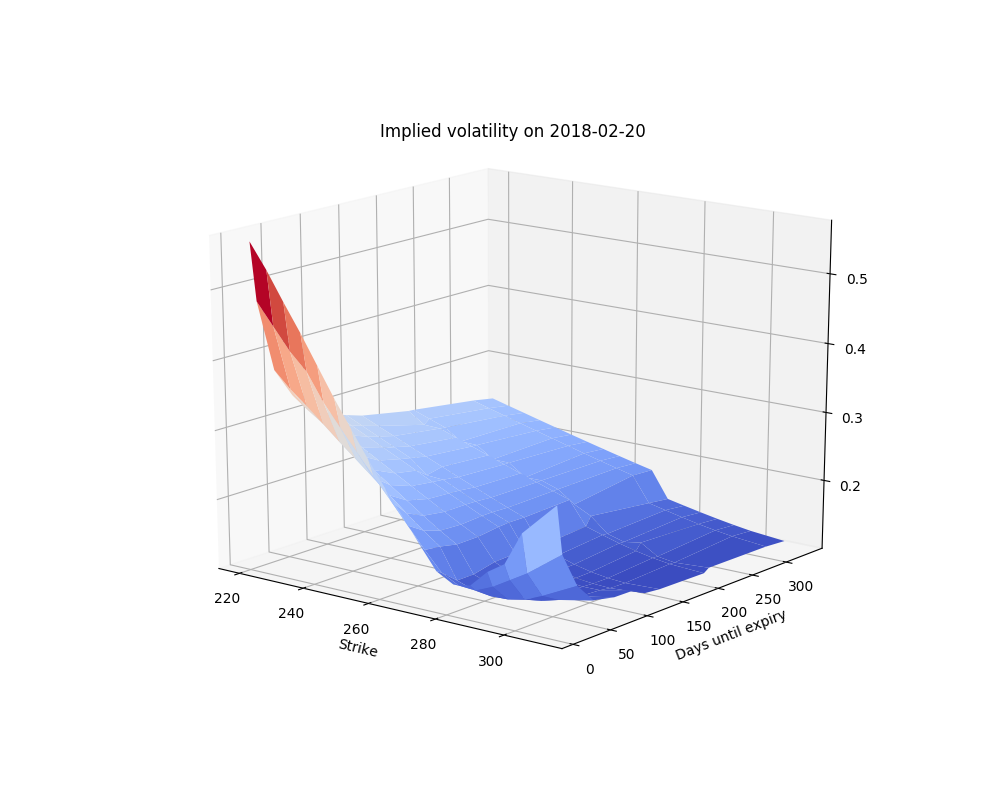

In [9]:
X = list(df)
Y = df.index.values
X, Y = np.meshgrid(X, Y)
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, iv, cmap=cm.coolwarm)
ax.xaxis.set_label_text('Strike')
ax.yaxis.set_label_text('Days until expiry')
date = dt.datetime.strftime(date, "%Y-%m-%d")
title_text = "Implied volatility on %s" % date
ax.set_title(title_text)
plt.show()